In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark.sql.functions as func
from pyspark.sql import Window

In [2]:
sc = SparkContext(appName="analysis2")
spark = SparkSession(sc)

In [3]:
df = spark.read.csv("./analysis_input/", header=True, inferSchema=True)
df.show(10)

+---+------+-----+----+----------+------------+--------+--------------+----------------+----+------------------+--------------------+------------------+------------------+-----+------+-----+------+------+------+------+-----+------+-----+------+------+------+------+------+------+------+------+------+------+------+------+-----+------+-------+-------+-------+-------+-------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+
|uid|app_id|index|year|popularity|review_score|discount|historical_low|sale_price_scale|days|sale_increase_rate|normal_increase_rate|        effect_min|       effect_plus|gen_1|gen_18|gen_2|gen_23|gen_25|gen_28|gen_29|gen_3|gen_37|gen_4|gen_51|gen_53|gen_54|gen_56|gen_57|gen_58|gen_60|gen_70|gen_71|gen_72|gen_73|gen_74|gen_9|cate_1|cate_13|cate_14|cate_15|cate_16|cate_17|cate_18|cate_2|cate_20

In [4]:
df.printSchema()

root
 |-- uid: integer (nullable = true)
 |-- app_id: integer (nullable = true)
 |-- index: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- review_score: integer (nullable = true)
 |-- discount: integer (nullable = true)
 |-- historical_low: integer (nullable = true)
 |-- sale_price_scale: integer (nullable = true)
 |-- days: integer (nullable = true)
 |-- sale_increase_rate: double (nullable = true)
 |-- normal_increase_rate: double (nullable = true)
 |-- effect_min: double (nullable = true)
 |-- effect_plus: double (nullable = true)
 |-- gen_1: integer (nullable = true)
 |-- gen_18: integer (nullable = true)
 |-- gen_2: integer (nullable = true)
 |-- gen_23: integer (nullable = true)
 |-- gen_25: integer (nullable = true)
 |-- gen_28: integer (nullable = true)
 |-- gen_29: integer (nullable = true)
 |-- gen_3: integer (nullable = true)
 |-- gen_37: integer (nullable = true)
 |-- gen_4: integer (nullable = true)
 |-- gen_5

In [5]:
df.count() == df.dropna().count()

True

In [7]:
print(df.columns)

['uid', 'app_id', 'index', 'year', 'popularity', 'review_score', 'discount', 'historical_low', 'sale_price_scale', 'days', 'sale_increase_rate', 'normal_increase_rate', 'effect_min', 'effect_plus', 'gen_1', 'gen_18', 'gen_2', 'gen_23', 'gen_25', 'gen_28', 'gen_29', 'gen_3', 'gen_37', 'gen_4', 'gen_51', 'gen_53', 'gen_54', 'gen_56', 'gen_57', 'gen_58', 'gen_60', 'gen_70', 'gen_71', 'gen_72', 'gen_73', 'gen_74', 'gen_9', 'cate_1', 'cate_13', 'cate_14', 'cate_15', 'cate_16', 'cate_17', 'cate_18', 'cate_2', 'cate_20', 'cate_22', 'cate_23', 'cate_24', 'cate_25', 'cate_27', 'cate_28', 'cate_29', 'cate_30', 'cate_31', 'cate_32', 'cate_35', 'cate_36', 'cate_37', 'cate_38', 'cate_39', 'cate_40', 'cate_41', 'cate_42', 'cate_43', 'cate_44', 'cate_47', 'cate_48', 'cate_49', 'cate_51', 'cate_8', 'cate_9']


In [4]:
non_feature = ['uid', 'app_id', 'sale_increase_rate', 'normal_increase_rate', 'effect_min', 'effect_plus', 'year']
featureCols = [x for x in df.columns if x not in non_feature]
print(featureCols)

['index', 'popularity', 'review_score', 'discount', 'historical_low', 'sale_price_scale', 'days', 'gen_1', 'gen_18', 'gen_2', 'gen_23', 'gen_25', 'gen_28', 'gen_29', 'gen_3', 'gen_37', 'gen_4', 'gen_51', 'gen_53', 'gen_54', 'gen_56', 'gen_57', 'gen_58', 'gen_60', 'gen_70', 'gen_71', 'gen_72', 'gen_73', 'gen_74', 'gen_9', 'cate_1', 'cate_13', 'cate_14', 'cate_15', 'cate_16', 'cate_17', 'cate_18', 'cate_2', 'cate_20', 'cate_22', 'cate_23', 'cate_24', 'cate_25', 'cate_27', 'cate_28', 'cate_29', 'cate_30', 'cate_31', 'cate_32', 'cate_35', 'cate_36', 'cate_37', 'cate_38', 'cate_39', 'cate_40', 'cate_41', 'cate_42', 'cate_43', 'cate_44', 'cate_47', 'cate_48', 'cate_49', 'cate_51', 'cate_8', 'cate_9']


In [33]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

#Linear
final_df = df.select(featureCols + ['effect_min'])

# final_df = final_df.where(final_df['effect_min'] < 1000)

assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
assembled_df = assembler.transform(final_df)
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

train_data, test_data = scaled_df.randomSplit([.7, .3], seed=1339)

lr = (LinearRegression(featuresCol='features_scaled', labelCol="effect_min", predictionCol='effect_min_pred',
                       maxIter=100, standardization=False))
linearModel = lr.fit(train_data)
predictions = linearModel.transform(test_data)

pred_and_labels = predictions.select("effect_min_pred", "effect_min")

evaluator = RegressionEvaluator(predictionCol='effect_min_pred', labelCol='effect_min', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='effect_min_pred', labelCol='effect_min', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='effect_min_pred', labelCol='effect_min', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(pred_and_labels)))


print("=============")

# Random Forest
rf = RandomForestRegressor(labelCol="effect_min", featuresCol="features", predictionCol='effect_min_pred')

rfModel = rf.fit(train_data)
predictions = rfModel.transform(test_data)

pred_and_labels = predictions.select("effect_min_pred", "effect_min")

evaluator = RegressionEvaluator(predictionCol='effect_min_pred', labelCol='effect_min', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='effect_min_pred', labelCol='effect_min', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='effect_min_pred', labelCol='effect_min', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(pred_and_labels)))

RMSE: 42.04728360688078
MAE: 9.577245939809526
R2: 0.15846419701000447
RMSE: 40.255875842063155
MAE: 7.625474255919365
R2: 0.22864327672405127


In [21]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

#Linear
final_df = df.select(featureCols + ['effect_plus'])

# final_df = final_df.where(final_df['effect_plus'] < 1000)

assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
assembled_df = assembler.transform(final_df)
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

train_data, test_data = scaled_df.randomSplit([.7, .3], seed=1339)

lr = (LinearRegression(featuresCol='features_scaled', labelCol="effect_plus", predictionCol='effect_plus_pred',
                       maxIter=100, standardization=False))
linearModel = lr.fit(train_data)
predictions = linearModel.transform(test_data)

pred_and_labels = predictions.select("effect_plus_pred", "effect_plus")

evaluator = RegressionEvaluator(predictionCol='effect_plus_pred', labelCol='effect_plus', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='effect_plus_pred', labelCol='effect_plus', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='effect_plus_pred', labelCol='effect_plus', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(pred_and_labels)))


print("=============")

# Random Forest
rf = RandomForestRegressor(labelCol="effect_plus", featuresCol="features", predictionCol='effect_plus_pred')

rfModel = rf.fit(train_data)
predictions = rfModel.transform(test_data)

pred_and_labels = predictions.select("effect_plus_pred", "effect_plus")

evaluator = RegressionEvaluator(predictionCol='effect_plus_pred', labelCol='effect_plus', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='effect_plus_pred', labelCol='effect_plus', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='effect_plus_pred', labelCol='effect_plus', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(pred_and_labels)))

RMSE: 60.54401031178183
MAE: 16.226565802387935
R2: 0.5592337384094652
RMSE: 67.13509009397694
MAE: 15.105675712352076
R2: 0.4580426288218925


In [8]:
res_df = pred_and_labels.toPandas()
res_df.head()

,effect_plus_pred,effect_plus
0,15.459413,5.019481
1,1.269980,17.500000
2,9.813061,2.625000
3,16.226790,26.125000
4,11.323741,0.197995


In [9]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

<AxesSubplot: >

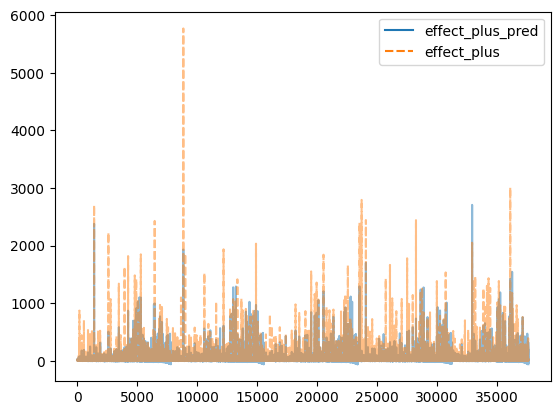

In [14]:
sns.lineplot(data=res_df, alpha=0.5)

In [42]:
importances = rfModel.featureImportances
x_values = list(range(len(importances)))
importance_dic = dict(zip(featureCols, importances.toArray()))
importance_dic = dict(sorted(importance_dic.items(), key=lambda item: item[1], reverse=True))
feature_extract = list(importance_dic)[:10]

In [ ]:
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, featureCols, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [38]:
def find_outliers(df, cols):

    for column in cols:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        IQR = Q3[0] - Q1[0]
        
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol, func.when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]

    df = df.withColumn('total_outliers',sum(df[column] for column in selected_columns))

    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

new_df = find_outliers(df, ['sale_increase_rate', 'normal_increase_rate', 'effect_min', 'effect_plus'])
no_outliers_df = new_df.filter(new_df['total_Outliers']<=1)
no_outliers_df = no_outliers_df.select(*df.columns)
no_outliers_df.count()

79868

In [41]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

#Linear
final_df = no_outliers_df.select(featureCols + ['effect_min'])

# final_df = final_df.where(final_df['effect_min'] < 1000)

assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
assembled_df = assembler.transform(final_df)
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

train_data, test_data = scaled_df.randomSplit([.65, .35], seed=1339)

lr = (LinearRegression(featuresCol='features_scaled', labelCol="effect_min", predictionCol='effect_min_pred',
                       maxIter=100, standardization=False))
linearModel = lr.fit(train_data)
predictions = linearModel.transform(test_data)

pred_and_labels = predictions.select("effect_min_pred", "effect_min")

evaluator = RegressionEvaluator(predictionCol='effect_min_pred', labelCol='effect_min', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='effect_min_pred', labelCol='effect_min', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='effect_min_pred', labelCol='effect_min', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(pred_and_labels)))


print("=============")

# Random Forest
rf = RandomForestRegressor(labelCol="effect_min", featuresCol="features", predictionCol='effect_min_pred')

rfModel = rf.fit(train_data)
predictions = rfModel.transform(test_data)

pred_and_labels = predictions.select("effect_min_pred", "effect_min")

evaluator = RegressionEvaluator(predictionCol='effect_min_pred', labelCol='effect_min', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='effect_min_pred', labelCol='effect_min', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='effect_min_pred', labelCol='effect_min', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(pred_and_labels)))

RMSE: 1.7274383552192503
MAE: 1.133356426826528
R2: 0.11958090146526268
RMSE: 1.6621913622649362
MAE: 1.060230675222858
R2: 0.1848333928673065


In [42]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

#Linear
final_df = no_outliers_df.select(featureCols + ['effect_plus'])

# final_df = final_df.where(final_df['effect_plus'] < 1000)

assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
assembled_df = assembler.transform(final_df)
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

train_data, test_data = scaled_df.randomSplit([.6, .4], seed=1339)

lr = (LinearRegression(featuresCol='features_scaled', labelCol="effect_plus", predictionCol='effect_plus_pred',
                       maxIter=100, standardization=False))
linearModel = lr.fit(train_data)
predictions = linearModel.transform(test_data)

pred_and_labels = predictions.select("effect_plus_pred", "effect_plus")

evaluator = RegressionEvaluator(predictionCol='effect_plus_pred', labelCol='effect_plus', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='effect_plus_pred', labelCol='effect_plus', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='effect_plus_pred', labelCol='effect_plus', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(pred_and_labels)))


print("=============")

# Random Forest
rf = RandomForestRegressor(labelCol="effect_plus", featuresCol="features", predictionCol='effect_plus_pred')

rfModel = rf.fit(train_data)
predictions = rfModel.transform(test_data)

pred_and_labels = predictions.select("effect_plus_pred", "effect_plus")

evaluator = RegressionEvaluator(predictionCol='effect_plus_pred', labelCol='effect_plus', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='effect_plus_pred', labelCol='effect_plus', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='effect_plus_pred', labelCol='effect_plus', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(pred_and_labels)))

RMSE: 3.2243652674472782
MAE: 2.2584465431817025
R2: 0.3850805059347121
RMSE: 2.993108533976669
MAE: 2.072564866785788
R2: 0.47012342198783863


In [43]:
sc.stop()